In [8]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm


In [9]:
# Load the dataset
df = pd.read_csv("20230404 BWARS public data.csv", sep=",")  # Adjust separator if needed
pest_df = pd.read_csv("pesticideusage.csv")


In [10]:
# Rename columns for clarity
df.columns = ["tik", "binomial", "osgr", "easting", "northing", "accuracy", "datum", "date", "poo"]
pest_df.columns = ["year", "region", "pesticide", "weight_applied", "area_treated"]

# Convert date columns and extract the year (filtering for 1995 onwards)
df["date"] = pd.to_datetime(df["date"], errors="coerce", dayfirst=True)
df["year"] = df["date"].dt.year
df = df[df["year"] >= 1995]

# Fix date parsing for pesticide data
pest_df["year"] = pd.to_numeric(pest_df["year"], errors="coerce")
pest_df = pest_df[pest_df["year"] >= 1995]

# Extract species name (before the first ":")
df["species"] = df["binomial"].apply(lambda x: re.match(r"^[^:]+", str(x)).group(0) if pd.notna(x) else x)


In [11]:

# Assign regions based on easting and northing
def assign_region(easting, northing):
    if pd.isna(easting) or pd.isna(northing):
        return "Unknown"
    elif 500000 <= easting <= 650000 and 200000 <= northing <= 400000:
        return "Eastern"
    elif 400000 <= easting <= 500000 and 200000 <= northing <= 400000:
        return "Midlands"
    elif 300000 <= easting <= 400000 and 400000 <= northing <= 600000:
        return "Northern"
    elif 500000 <= easting <= 650000 and 0 <= northing <= 200000:
        return "South Eastern"
    elif 300000 <= easting <= 500000 and 0 <= northing <= 200000:
        return "South Western"
    elif 100000 <= easting <= 400000 and 600000 <= northing <= 1000000:
        return "Scotland"
    elif 200000 <= easting <= 300000 and 200000 <= northing <= 400000:
        return "Wales"
    elif 0 <= easting <= 200000 and 300000 <= northing <= 500000:
        return "Northern Ireland"
    else:
        return "Unknown"

# Apply the function to assign regions
df['Region'] = df.apply(lambda row: assign_region(row['easting'], row['northing']), axis=1)

# Drop rows where region is unknown
df = df[df["Region"] != "Unknown"]

# Create unique coordinate labels
df['osgr'] = df['easting'].astype(str) + "_" + df['northing'].astype(str)

# Assign site IDs by region
df['Site'] = (
    df.groupby('Region')['osgr']
    .transform(lambda x: pd.factorize(x)[0] + 1)
    .astype(str)
)

# Prefix site IDs with region initials
df['Site'] = df['Region'].str[0] + df['Site']

In [12]:
# Count detections per site-species-year
df_occupancy = df.groupby(["Site", "species", "year", "Region"]).size().reset_index(name="detections")
df_occupancy["occupancy"] = 1  # Species detected → occupancy = 1

# Create full grid for valid species-region-year combinations
valid_site_species = df[["Site", "species"]].drop_duplicates()

all_years = np.arange(df["year"].min(), (df["year"].max() + 1))

valid_grid = valid_site_species.assign(key=1).merge(
    pd.DataFrame({"year": all_years, "key": 1}), on="key"
).drop("key", axis=1)

# Merge occupancy data onto the valid grid (fill NaN with 0 for absence)
df_occupancy = valid_grid.merge(df_occupancy, on=["Site", "species", "year"], how="left").fillna(0)


In [13]:
print('df:', df.columns)
print('df_occ:', df_occupancy.columns)

df: Index(['tik', 'binomial', 'osgr', 'easting', 'northing', 'accuracy', 'datum',
       'date', 'poo', 'year', 'species', 'Region', 'Site'],
      dtype='object')
df_occ: Index(['Site', 'species', 'year', 'Region', 'detections', 'occupancy'], dtype='object')


In [32]:
# Group and calculate trends for different bee species
bombus_trend = df_occupancy[df_occupancy['species'].str.startswith('Bombus')].groupby('year')['detections'].sum().reset_index()
apis_trend = df_occupancy[df_occupancy['species'].str.startswith('Apis')].groupby('year')['detections'].sum().reset_index()
solitary_trend = df_occupancy[df_occupancy['species'].str.startswith(('Osmia', 'Andrena', 'Xylocopa'))].groupby('year')['detections'].sum().reset_index()

# Prepare pesticide data
pest_df['weight_applied'] = pd.to_numeric(pest_df['weight_applied'], errors='coerce')
pesticide_trend = pest_df.groupby('year')['weight_applied'].sum().reset_index()

Index(['Site', 'species', 'year', 'Region', 'detections', 'occupancy'], dtype='object')


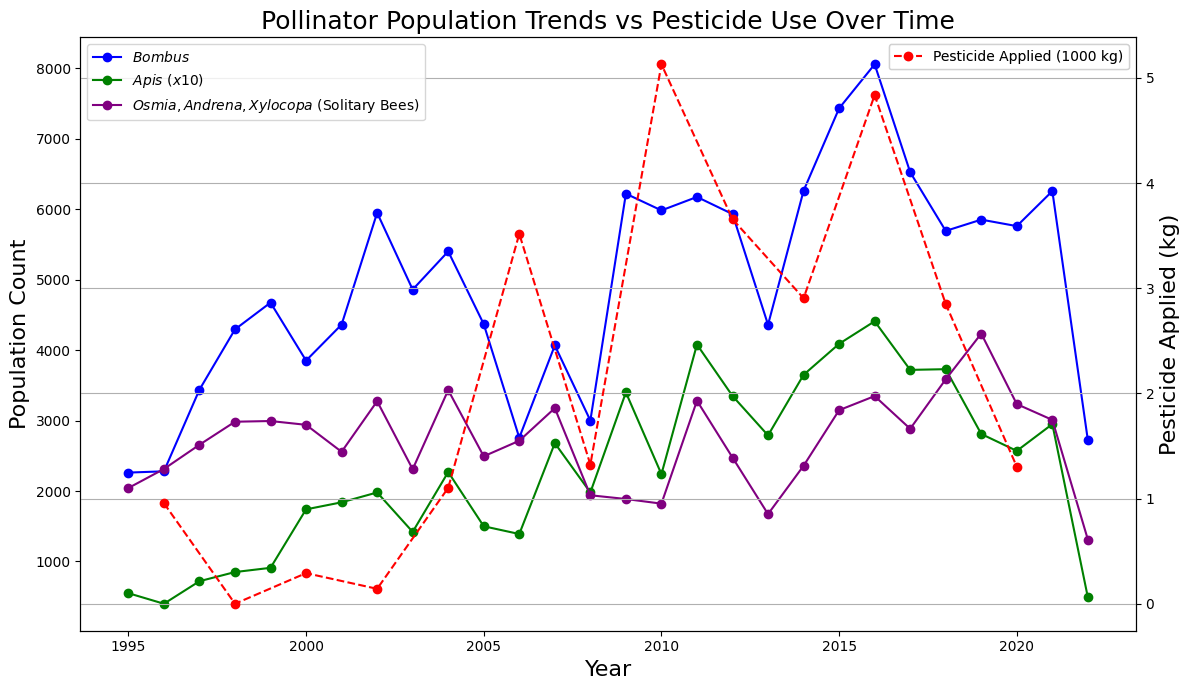

In [111]:
# Plotting
fig, ax1 = plt.subplots(figsize=(12, 7))

# Bee species data with explicit labels for the legend
line_bombus, = plt.plot(bombus_trend['year'], bombus_trend['detections'], marker='o',
         label=r'$\it{Bombus}$', color='blue')
line_apis, = plt.plot(apis_trend['year'], apis_trend['detections']*10, marker='o', 
        label=r'$\it{Apis\ (x10)}$', color='green')
line_solitary, = plt.plot(solitary_trend['year'], solitary_trend['detections'], marker='o', 
        label=r'$\it{Osmia, Andrena, Xylocopa}$ (Solitary Bees)', color='purple')

# Pesticide data on secondary axis with label
ax2 = plt.gca().twinx()
line_pesticide, = ax2.plot(pesticide_trend['year'], pesticide_trend['weight_applied'] / 1000, 
         label='Pesticide Applied (1000 kg)', color='red', marker='o', linestyle='dashed')


# Graph styling
ax1.set_title('Pollinator Population Trends vs Pesticide Use Over Time', size=18)
ax1.set_xlabel('Year', size=16)
ax1.set_ylabel('Population Count', size=16)
ax2.set_ylabel('Pesticide Applied (kg)', size=16)

# Display the legend for both axes separately
legend1 = plt.legend(handles=[line_bombus, line_apis, line_solitary], loc='upper left')
legend2 = ax2.legend(handles=[line_pesticide], loc='upper right')

plt.gca().add_artist(legend1)
ax2.add_artist(legend2)

plt.tight_layout()


plt.grid(True)
plt.show()


In [85]:
# Merge the datasets on 'year' to align bee population and pesticide usage
merged_data = pd.merge(bombus_trend, pesticide_trend, on="year", how="inner")
merged_data = pd.merge(merged_data, apis_trend, on="year", how="inner")
merged_data = pd.merge(merged_data, solitary_trend, on="year", how="inner")

print('merge:', merged_data.columns)
print(merged_data.head())

merge: Index(['year', 'detections_x', 'weight_applied', 'detections_y', 'detections'], dtype='object')
     year  detections_x  weight_applied  detections_y  detections
0  1996.0        2280.0           956.0          40.0      2313.0
1  1998.0        4295.0             0.0          85.0      2984.0
2  2000.0        3852.0           291.0         174.0      2940.0
3  2002.0        5950.0           142.0         198.0      3275.0
4  2004.0        5402.0          1102.0         227.0      3433.0


In [95]:
from scipy.stats import pearsonr, spearmanr

# Calculate Pearson correlation and p-value for Bombus and pesticide
corr_bombus, p_value_bombus = stats.pearsonr(merged_data['detections_x'], merged_data['weight_applied'])

# Calculate Pearson correlation and p-value for Apis and pesticide
corr_apis, p_value_apis = stats.pearsonr(merged_data['detections_y'], merged_data['weight_applied'])

#Calculate Pearson correlation and p-value for Solitary Bees and Pesticide
corr_sol, p_value_sol = stats.pearsonr(merged_data['detections'], merged_data['weight_applied'])

# Output correlation results
print(f"Pearson correlation between Bombus and pesticide: {corr_bombus}")
print(f"P-value for Bombus and pesticide: {p_value_bombus}")
print(f"Pearson correlation between Apis and pesticide: {corr_apis}")
print(f"P-value for Apis and pesticide: {p_value_apis}")
print(f"Pearson correlation between Solitary Bees and pesticide: {corr_sol}")
print(f"P-value for Solitary and pesticide: {p_value_sol}")

spear_bombus_corr, spear_bom_p_value = spearmanr(merged_data['weight_applied'], merged_data['detections_x'])
print(f"Spearman correlation: {spear_bombus_corr}, p-value: {spear_bom_p_value}")
spear_apis_corr, spear_apis_p_value = spearmanr(merged_data['weight_applied'], merged_data['detections_y'])
print(f"Spearman correlation: {spear_apis_corr}, p-value: {spear_apis_p_value}")
spear_sol_corr, spear_sol_p_value = spearmanr(merged_data['weight_applied'], merged_data['detections'])
print(f"Spearman correlation: {spear_sol_corr}, p-value: {spear_sol_p_value}")


Pearson correlation between Bombus and pesticide: 0.46913279603740526
P-value for Bombus and pesticide: 0.10582413393118029
Pearson correlation between Apis and pesticide: 0.603273782269701
P-value for Apis and pesticide: 0.02904972768801204
Pearson correlation between Solitary Bees and pesticide: -0.2593730041182983
P-value for Apis and pesticide: 0.39214190089820716
Spearman correlation: 0.46703296703296704, p-value: 0.1076091403991392
Spearman correlation: 0.5859702929929769, p-value: 0.035336924718254434
Spearman correlation: -0.26373626373626374, p-value: 0.3839365166506742


In [99]:
# Create lagged pesticide data
for lag in range(1, 4):
    merged_data[f'pesticide_lag_{lag}'] = merged_data['weight_applied'].shift(lag)

# Pearson Correlation with lags
for species, label in zip(['detections_x', 'detections_y', 'detections'], 
                          ['Bombus', 'Apis', 'Solitary']):
    print(f"\n=== Pearson Correlation for {label} ===")
    for lag in range(1, 4):
        valid_data = merged_data[[species, f'pesticide_lag_{lag}']].dropna()
        corr, p_value = pearsonr(valid_data[species], valid_data[f'pesticide_lag_{lag}'])
        print(f"Pearson correlation with {lag}-year lag: {corr}, p-value: {p_value}")

# Spearman Correlation with lags
for species, label in zip(['detections_x', 'detections_y', 'detections'], 
                          ['Bombus', 'Apis', 'Solitary']):
    print(f"\n=== Spearman Correlation for {label} ===")
    for lag in range(1, 4):
        valid_data = merged_data[[species, f'pesticide_lag_{lag}']].dropna()
        corr, p_value = spearmanr(valid_data[species], valid_data[f'pesticide_lag_{lag}'])
        print(f"Spearman correlation with {lag}-year lag: {corr}, p-value: {p_value}")



=== Pearson Correlation for Bombus ===
Pearson correlation with 1-year lag: 0.28772639150017654, p-value: 0.3644846573365236
Pearson correlation with 2-year lag: 0.5641646683104362, p-value: 0.07062948812742254
Pearson correlation with 3-year lag: 0.6994698014964686, p-value: 0.024360529725169573

=== Pearson Correlation for Apis ===
Pearson correlation with 1-year lag: 0.692807654056471, p-value: 0.012502818100628438
Pearson correlation with 2-year lag: 0.6276408436706504, p-value: 0.03869652015178986
Pearson correlation with 3-year lag: 0.8372344690912819, p-value: 0.0025106093544658642

=== Pearson Correlation for Solitary ===
Pearson correlation with 1-year lag: -0.15247416161435318, p-value: 0.6361612274983515
Pearson correlation with 2-year lag: -0.09420758720719401, p-value: 0.7829209848609046
Pearson correlation with 3-year lag: 0.39864229392234535, p-value: 0.2538357335937447

=== Spearman Correlation for Bombus ===
Spearman correlation with 1-year lag: 0.3426573426573427, p-

Index(['year', 'detections_x', 'weight_applied', 'detections_y', 'detections',
       'pesticide_lag_1', 'pesticide_lag_2', 'pesticide_lag_3'],
      dtype='object')


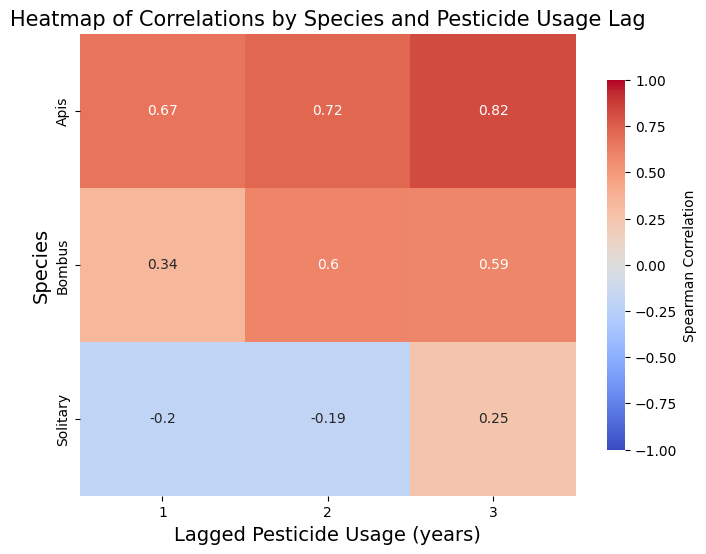

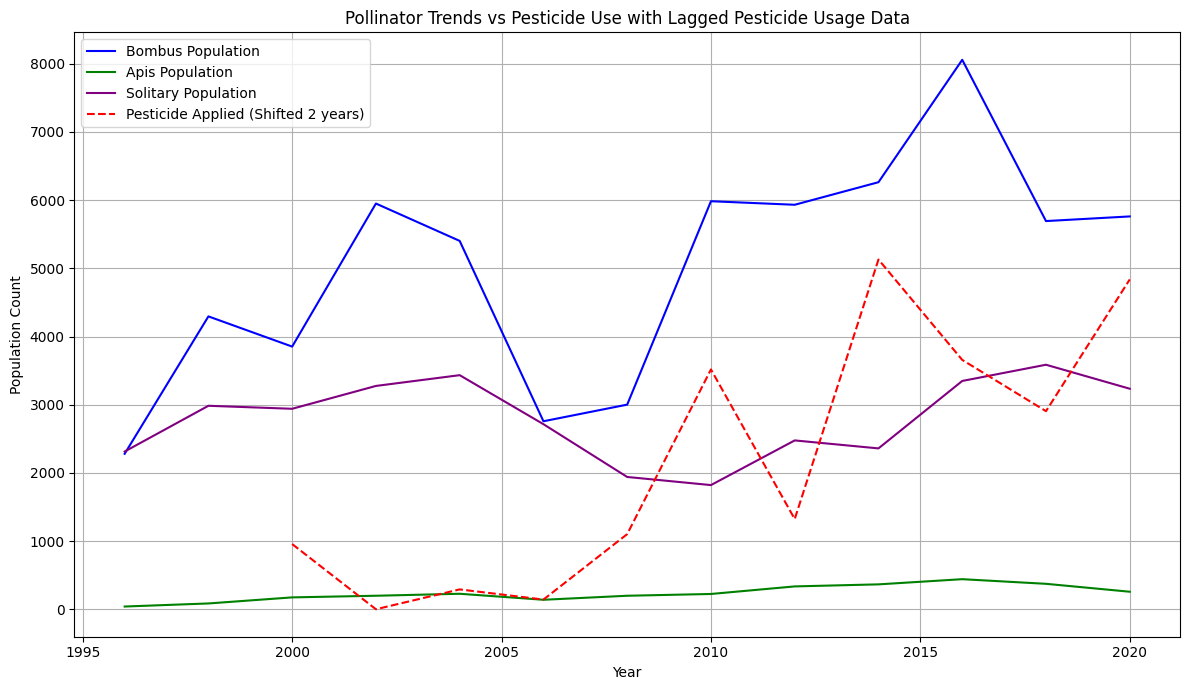

In [115]:
print(merged_data.columns)

import seaborn as sns

# Prepare correlation data for the heatmap
corr_data = []

# Loop through each species and calculate correlations with lags
for species, label in zip(['detections_x', 'detections_y', 'detections'], ['Bombus', 'Apis', 'Solitary']):
    for lag in range(1, 4):
        valid_data = merged_data[[species, f'pesticide_lag_{lag}']].dropna()
        
        # Spearman correlation
        corr, _ = spearmanr(valid_data[species], valid_data[f'pesticide_lag_{lag}'])
        corr_data.append([label, lag, corr])

# Create a DataFrame for the heatmap
corr_df = pd.DataFrame(corr_data, columns=['Species', 'Lag', 'Correlation'])

# Heatmap for correlation values
plt.figure(figsize=(8, 6))
heatmap_data = corr_df.pivot(index='Species', columns='Lag', values='Correlation')

sns.heatmap(heatmap_data, annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1,
            cbar_kws={"label": "Spearman Correlation", "shrink":0.8})

plt.title("Heatmap of Correlations by Species and Pesticide Usage Lag", size=15)
plt.xlabel("Lagged Pesticide Usage (years)", size=14)
plt.ylabel("Species", size=14)
plt.show()

# Line plot for best-fit lag visualization
plt.figure(figsize=(12, 7))

# Assuming merged_data has columns 'year' for years and 'detections_x', 'detections_y', 'detections' for population data
for species, label, color in zip(['detections_x', 'detections_y', 'detections'], 
                                 ['Bombus Population', 'Apis Population', 'Solitary Population'],
                                 ['blue', 'green', 'purple']):
    plt.plot(merged_data['year'], merged_data[species], label=label, color=color)

# Plot pesticide trend (shifted for best correlation, assuming lag 2 for example)
merged_data['pesticide_lag_2'] = merged_data['weight_applied'].shift(2)
plt.plot(merged_data['year'], merged_data['pesticide_lag_2'], label='Pesticide Applied (Shifted 2 years)', color='red', linestyle='dashed')

# Styling for the line plot
plt.title("Pollinator Trends vs Pesticide Use with Lagged Pesticide Usage Data")
plt.xlabel("Year")
plt.ylabel("Population Count")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [92]:
# Regression Analysis for Bombus and pesticide
X_bombus = sm.add_constant(merged_data['weight_applied'])  # Add intercept
y_bombus = merged_data['detections_x']  # Bombus detections
model_bombus = sm.OLS(y_bombus, X_bombus).fit()

# Display Bombus regression results
print("Bombus Model Summary:")
print(model_bombus.summary())


Bombus Model Summary:
                            OLS Regression Results                            
Dep. Variable:           detections_x   R-squared:                       0.220
Model:                            OLS   Adj. R-squared:                  0.149
Method:                 Least Squares   F-statistic:                     3.104
Date:                Sun, 09 Mar 2025   Prob (F-statistic):              0.106
Time:                        22:09:16   Log-Likelihood:                -112.71
No. Observations:                  13   AIC:                             229.4
Df Residuals:                      11   BIC:                             230.6
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           4065.0

c:\Users\ellag\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  k, _ = kurtosistest(a, axis)


In [29]:
# Regression Analysis for Apis and pesticide
X_apis = sm.add_constant(merged_data['weight_applied'])  # Add intercept
y_apis = merged_data['detections_y']  # Apis detections
model_apis = sm.OLS(y_apis, X_apis).fit()

# Display Apis regression results
print("Apis Model Summary:")
print(model_apis.summary())

Apis Model Summary:
                            OLS Regression Results                            
Dep. Variable:           detections_y   R-squared:                       0.364
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     6.294
Date:                Sun, 09 Mar 2025   Prob (F-statistic):             0.0290
Time:                        12:15:55   Log-Likelihood:                -76.932
No. Observations:                  13   AIC:                             157.9
Df Residuals:                      11   BIC:                             159.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const            148.588

c:\Users\ellag\AppData\Local\Programs\Python\Python312\Lib\site-packages\scipy\stats\_stats_py.py:1971: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=13
  k, _ = kurtosistest(a, axis)


In [110]:
# Merge df_occupancy with merged_data for Region and Site information
print(merged_data.columns)
print(df_occupancy.columns)
import pandas as pd
import statsmodels.api as sm

# Merge df_occupancy with merged_data for Region and Site information
merged_data = pd.merge(merged_data, df_occupancy[['Site', 'year', 'Region']], on=['Site', 'year'], how='left')

# Check if the merge was successful and see the resulting columns
print(merged_data.columns)

# Create dummy variables for the 'Region' column (ensure drop_first to avoid multicollinearity)
region_dummies = pd.get_dummies(merged_data['Region'], drop_first=True)

# Add the dummies to the dataset along with 'weight_applied'
X_multiple = pd.concat([merged_data[['weight_applied']], region_dummies], axis=1)

# Add constant (intercept) to the model
X_multiple = sm.add_constant(X_multiple)

# Set the dependent variable: 'detections_y' (Apis detections)
y_multiple = merged_data['detections_y']  # Apis detections

# Fit the multiple regression model
model_multiple = sm.OLS(y_multiple, X_multiple).fit()

# Display the multiple regression results
print("Multiple Regression Model Summary:")
print(model_multiple.summary())


Index(['year', 'detections_x', 'weight_applied', 'detections_y', 'detections',
       'pesticide_lag_1', 'pesticide_lag_2', 'pesticide_lag_3'],
      dtype='object')
Index(['Site', 'species', 'year', 'Region', 'detections', 'occupancy'], dtype='object')


KeyError: 'Site'